# Model Linearity

## General definition

The model linearity module in alibi aims to provide a metric to measure how linear is a ML model. Linearity is defined based on how much the linear superposition of the model's outputs differs from the output of the same linear superposition of the inputs. 

Given $N$ input vectors $v_i$, $N$ real coefficients $\alpha_i$ and a predict function $\text{M}(v_i)$, the linearity of the predict function is defined as

$$L = \Big|\Big|\sum_i \alpha_i \cdot \text{M}(v_i) - \text{M}\Big(\sum_i \alpha \cdot v_i\Big) \Big|\Big|$$

If M is a regressor and as

$$L = \Big|\Big|\sum_i \alpha_i \cdot \log[\text{M}(v_i)] - \log\Big[\text{M}\Big(\sum_i \alpha \cdot v_i\Big)\Big] \Big|\Big|$$

if M is a classifier. 

## Alibi implementation
Based on the general definition above, alibi calculates the linearity of a model in the neighboorhood of a given instance $v_0$. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from itertools import product
from alibi.confidence.model_linearity import linearity_measure, LinearityMeasure

Using TensorFlow backend.


# Dataset
As an example, we will visualize the decision boundaries and the values of the liniarity measure for various classifier on the iris dataset. Only 2 features are included for visualization porpuses.

In [2]:
ds = load_iris()
X_train, y_train = ds.data[:, :2], ds.target

In [3]:
ds.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

# Models
We will experiment with 4 different classifiers:
* A logistic regression model, which is expected to be highly linear
* A random forest classifier, which is expected to be higly non linear
* A Xgboost classifier
* A support vector machines classifier

In [36]:
lr = LogisticRegression(fit_intercept=False, multi_class='multinomial', solver='newton-cg')
rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(n_estimators=100)
svm = SVC(gamma=.1, kernel='rbf', probability=True)

In [37]:
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Decision boundaries and linearity 

In [38]:
# Creating grid
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

In [39]:
# Flattening points in the grid
X = np.empty((len(xx.flatten()), 2))
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        k = i * xx.shape[1] + j
        X[k] = np.array([xx[i, j], yy[i, j]])

### Logistic regression

In [40]:
# Defining predict function for logistic regression
clf = lr
predict_fn = lambda x: clf.predict_proba(x)

In [41]:
# Calculating linearity for all points in the grid
lm = LinearityMeasure(agg='pairwise')
lm.fit(X_train)
L = lm.score(predict_fn, X)
L = L.reshape(xx.shape)

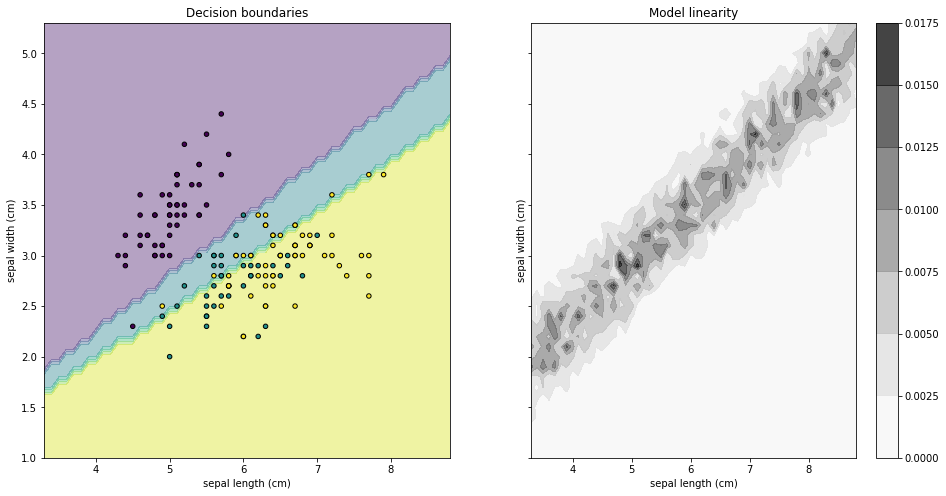

In [42]:
# Visualising decision boundaries and linearity values 
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 8))
idx = (0,0)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', alpha=1)
axarr[0].set_title('Decision boundaries')
axarr[0].set_xlabel('sepal length (cm)')
axarr[0].set_ylabel('sepal width (cm)')

LPL = axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
axarr[1].set_title('Model linearity')
axarr[1].set_xlabel('sepal length (cm)')
axarr[1].set_ylabel('sepal width (cm)')
cbar = f.colorbar(LPL)
#cbar.ax.set_ylabel('Linearity')
plt.show()

In [43]:
print('Maximum value model linearity: {}'. format(np.round(L.max(), 5))) 
print('Minimum value model linearity: {}'.format(np.round(L.min(),5)))

Maximum value model linearity: 0.01637
Minimum value model linearity: 0.0


### Random forest

In [44]:
# Defining predict function for random forest
clf = rf
predict_fn = lambda x: clf.predict_proba(x)

In [45]:
# Calculating linearity for all points in the grid
lm = LinearityMeasure(agg='pairwise')
lm.fit(X_train)
L = lm.score(predict_fn, X)
L = L.reshape(xx.shape)

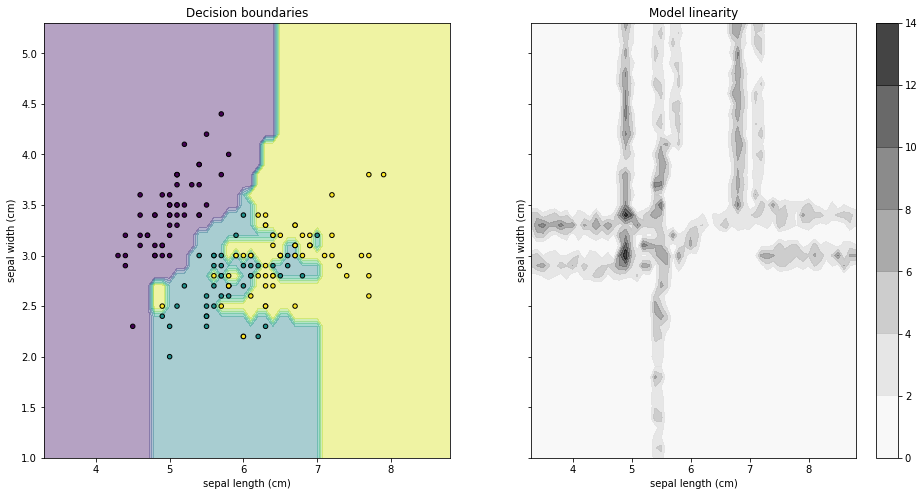

In [46]:
# Visualising decision boundaries and linearity values 
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 8))
idx = (0,0)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', alpha=1)
axarr[0].set_title('Decision boundaries')
axarr[0].set_xlabel('sepal length (cm)')
axarr[0].set_ylabel('sepal width (cm)')

LPL = axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
axarr[1].set_title('Model linearity')
axarr[1].set_xlabel('sepal length (cm)')
axarr[1].set_ylabel('sepal width (cm)')

cbar = f.colorbar(LPL)
plt.show()

In [47]:
print('Maximum value model linearity: {}'. format(np.round(L.max(), 5))) 
print('Minimum value model linearity: {}'.format(np.round(L.min(),5)))

Maximum value model linearity: 13.81722
Minimum value model linearity: 0.0


### Xgboost

In [29]:
# Defining predict function for xgboost
clf = xgb
predict_fn = lambda x: clf.predict_proba(x)

In [30]:
# Calculating linearity for all points in the grid
lm = LinearityMeasure(agg='pairwise')
lm.fit(X_train)
L = lm.score(predict_fn, X)
L = L.reshape(xx.shape)

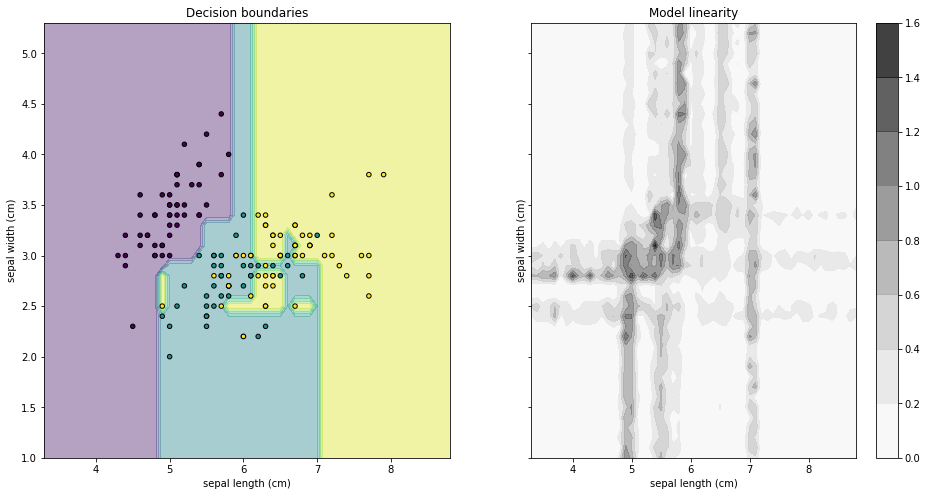

In [31]:
# Visualising decision boundaries and linearity values 
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 8))
idx = (0,0)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', alpha=1)
axarr[0].set_title('Decision boundaries')
axarr[0].set_xlabel('sepal length (cm)')
axarr[0].set_ylabel('sepal width (cm)')

LPL = axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
axarr[1].set_title('Model linearity')
axarr[1].set_xlabel('sepal length (cm)')
axarr[1].set_ylabel('sepal width (cm)')

cbar = f.colorbar(LPL)
#cbar.ax.set_ylabel('Linearity')
plt.show()

In [32]:
print('Maximum value model linearity: {}'. format(np.round(L.max(), 5))) 
print('Minimum value model linearity: {}'.format(np.round(L.min(),5)))

Maximum value model linearity: 1.4579
Minimum value model linearity: 0.0


### SVM

In [33]:
# Defining predict function for svm
clf = svm
predict_fn = lambda x: clf.predict_proba(x)

In [34]:
# Calculating linearity for all points in the grid
lm = LinearityMeasure(agg='global')
lm.fit(X_train)
L = lm.score(predict_fn, X)
L = L.reshape(xx.shape)

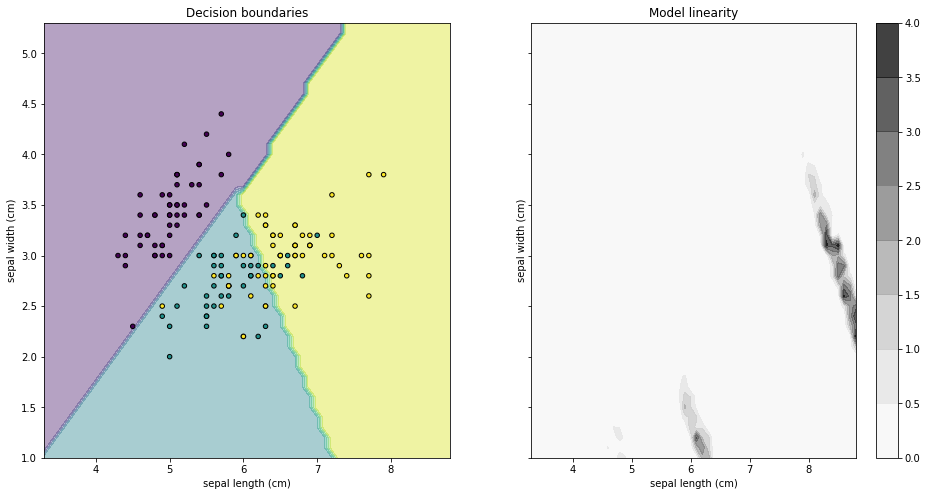

In [35]:
# Visualising decision boundaries and linearity values 
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 8))
idx = (0,0)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', alpha=1)
axarr[0].set_title('Decision boundaries')
axarr[0].set_xlabel('sepal length (cm)')
axarr[0].set_ylabel('sepal width (cm)')

LPL = axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
axarr[1].set_title('Model linearity')
axarr[1].set_xlabel('sepal length (cm)')
axarr[1].set_ylabel('sepal width (cm)')

cbar = f.colorbar(LPL)
#cbar.ax.set_ylabel('Linearity')
plt.show()

#axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
#axarr[1].set_title('Model linearity')
#plt.show()

In [120]:
print('Maximum value model linearity: {}'. format(np.round(L.max(), 5))) 
print('Minimum value model linearity: {}'.format(np.round(L.min(),5)))

Maximum value model linearity: 0.01742
Minimum value model linearity: 0.0
